# IMPORT LIBRARY

In [2]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
import optuna.integration.lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import warnings
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path
import os
import matplotlib.pyplot as plt 
from wordcloud  import WordCloud

from library.sb_utils import save_file
warnings.filterwarnings("ignore")

# LOAD DATA

In [9]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [4]:
data.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


In [5]:
test.head()

,discourse_id,essay_id,discourse_text,discourse_type
0,a261b6e14276,D72CB1C11673,Making choices in life can be very difficult. ...,Lead
1,5a88900e7dc1,D72CB1C11673,Seeking multiple opinions can help a person ma...,Position
2,9790d835736b,D72CB1C11673,it can decrease stress levels,Claim
3,75ce6d68b67b,D72CB1C11673,a great chance to learn something new,Claim
4,93578d946723,D72CB1C11673,can be very helpful and beneficial.,Claim


In [6]:
len(data)

36765

In [7]:
len(test)

10

In [11]:
duplicates = train[train.discourse_text.duplicated(keep=False)].sort_values(by="discourse_text")
duplicates.head(10)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
26691,7f9c3500259d,A602D45D22B2,"""That's a lava dome that takes the form of an ...",Evidence,Adequate
27350,d628a6adda3a,ADB68BCD2874,"""That's a lava dome that takes the form of an ...",Evidence,Adequate
25391,781452d9404c,942ECB176B3A,"At the most basic level, the electoral college...",Position,Adequate
28835,6fa171a95540,C2BAF4ADA2CA,"At the most basic level, the electoral college...",Claim,Adequate
28436,9e12ec699196,BB3A6C2D0B65,Big States,Claim,Adequate
20121,35bf70c4a673,4CA37D113612,Big States,Claim,Ineffective
3933,c5b2ecb3888e,44E2726DA1B3,I agree,Position,Adequate
11285,5e4022e93247,CB66B685DAF6,I agree,Position,Adequate
17087,99782ca26927,2714214F7D9E,I think students should be required to perform...,Position,Adequate
29590,33d6bbba823c,CE64FA08E4CF,I think students should be required to perform...,Position,Adequate


In [7]:
data.essay_id.value_counts()

91B1F82B2CF1    23
4CA37D113612    23
900A879708F0    23
A7EC6F462F8B    22
DECAE402BB38    22
                ..
AB02689C1A9B     1
FFFF80B8CC2F     1
377548575048     1
5E85F1FB4E22     1
9706F8E7D534     1
Name: essay_id, Length: 4191, dtype: int64

We can see there are totally over 4k essays in the dataset. Some of them have 23 rows at most, some of them have only one.

In [8]:
data.loc[data.essay_id=='91B1F82B2CF1'].head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
25190,2d4def8e7c09,91B1F82B2CF1,Many people may think that attending school on...,Lead,Adequate
25191,0a6634792991,91B1F82B2CF1,I would say that I disagree with that statemen...,Position,Adequate
25192,e73c3a854460,91B1F82B2CF1,"Yes, online school would be better for student...",Counterclaim,Adequate
25193,57d92e1dddb3,91B1F82B2CF1,but what about in the future when they lack ba...,Rebuttal,Adequate
25194,4e57f20c26e0,91B1F82B2CF1,"yes, the online courses could be more personal...",Counterclaim,Adequate


In [9]:
data.loc[data.essay_id=='DECAE402BB38'].head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
30625,668f35f67578,DECAE402BB38,The author presents both positive and negative...,Lead,Adequate
30626,3856e2bd8067,DECAE402BB38,In my opinion based on the reading there are m...,Position,Adequate
30627,49ca17796e68,DECAE402BB38,To begin with some positive aspects to driving...,Counterclaim,Effective
30628,08be5af2db06,DECAE402BB38,These driverless claim to use less gas than an...,Counterclaim,Effective
30629,6930c5951a8a,DECAE402BB38,But by using electricity it will likely increa...,Rebuttal,Effective


In [10]:
data.loc[data.essay_id=='9706F8E7D534']

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
8358,11057d62414d,9706F8E7D534,Luke Bomberger was just an ordanery small town...,Evidence,Ineffective


In [11]:
data.loc[data.essay_id=='5E85F1FB4E22']

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
21386,cf33e2c0a4cd,5E85F1FB4E22,Driverless cars may be modern and use half of ...,Evidence,Ineffective


In [12]:
data.discourse_type.value_counts()

Evidence                12105
Claim                   11977
Position                 4024
Concluding Statement     3351
Lead                     2291
Counterclaim             1773
Rebuttal                 1244
Name: discourse_type, dtype: int64

There are 7 types of discourse that are being annotated here. The data description for the competition provides more details:

Lead - an introduction that begins with a statistic, a quotation, a description, or some other device to grab the reader’s attention and point toward the thesis

Position - an opinion or conclusion on the main question

Claim - a claim that supports the position

Counterclaim - a claim that refutes another claim or gives an opposing reason to the position

Rebuttal - a claim that refutes a counterclaim

Evidence - ideas or examples that support claims, counterclaims, or rebuttals.

Concluding Statement - a concluding statement that restates the claims

"Evidence" is the most common type of discourse that is being annotated in this dataset.

In [13]:
data.discourse_effectiveness.value_counts()

Adequate       20977
Effective       9326
Ineffective     6462
Name: discourse_effectiveness, dtype: int64

There are three options: Ineffective, Effective, and Adequate. The data description provides more info:

Human readers rated each rhetorical or argumentative element, in order of increasing quality, as one of:

Ineffective

Adequate

Effective

In [14]:
highlight_color = 'cornflowerblue'

effectiveness_colors =  ['salmon', 'yellow', 'lightgreen']
effectiveness_order = ['Ineffective', 'Adequate', 'Effective']

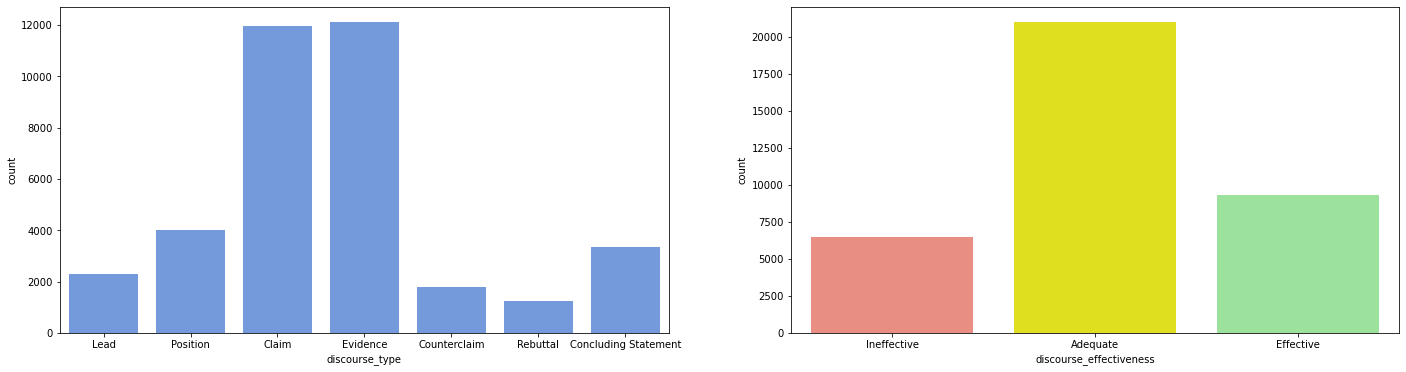

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))
sns.countplot(data = data, x = "discourse_type", ax = ax[0], color=highlight_color)
sns.countplot(data = data, x = "discourse_effectiveness", order = effectiveness_order, ax = ax[1], palette=effectiveness_colors)
plt.show()

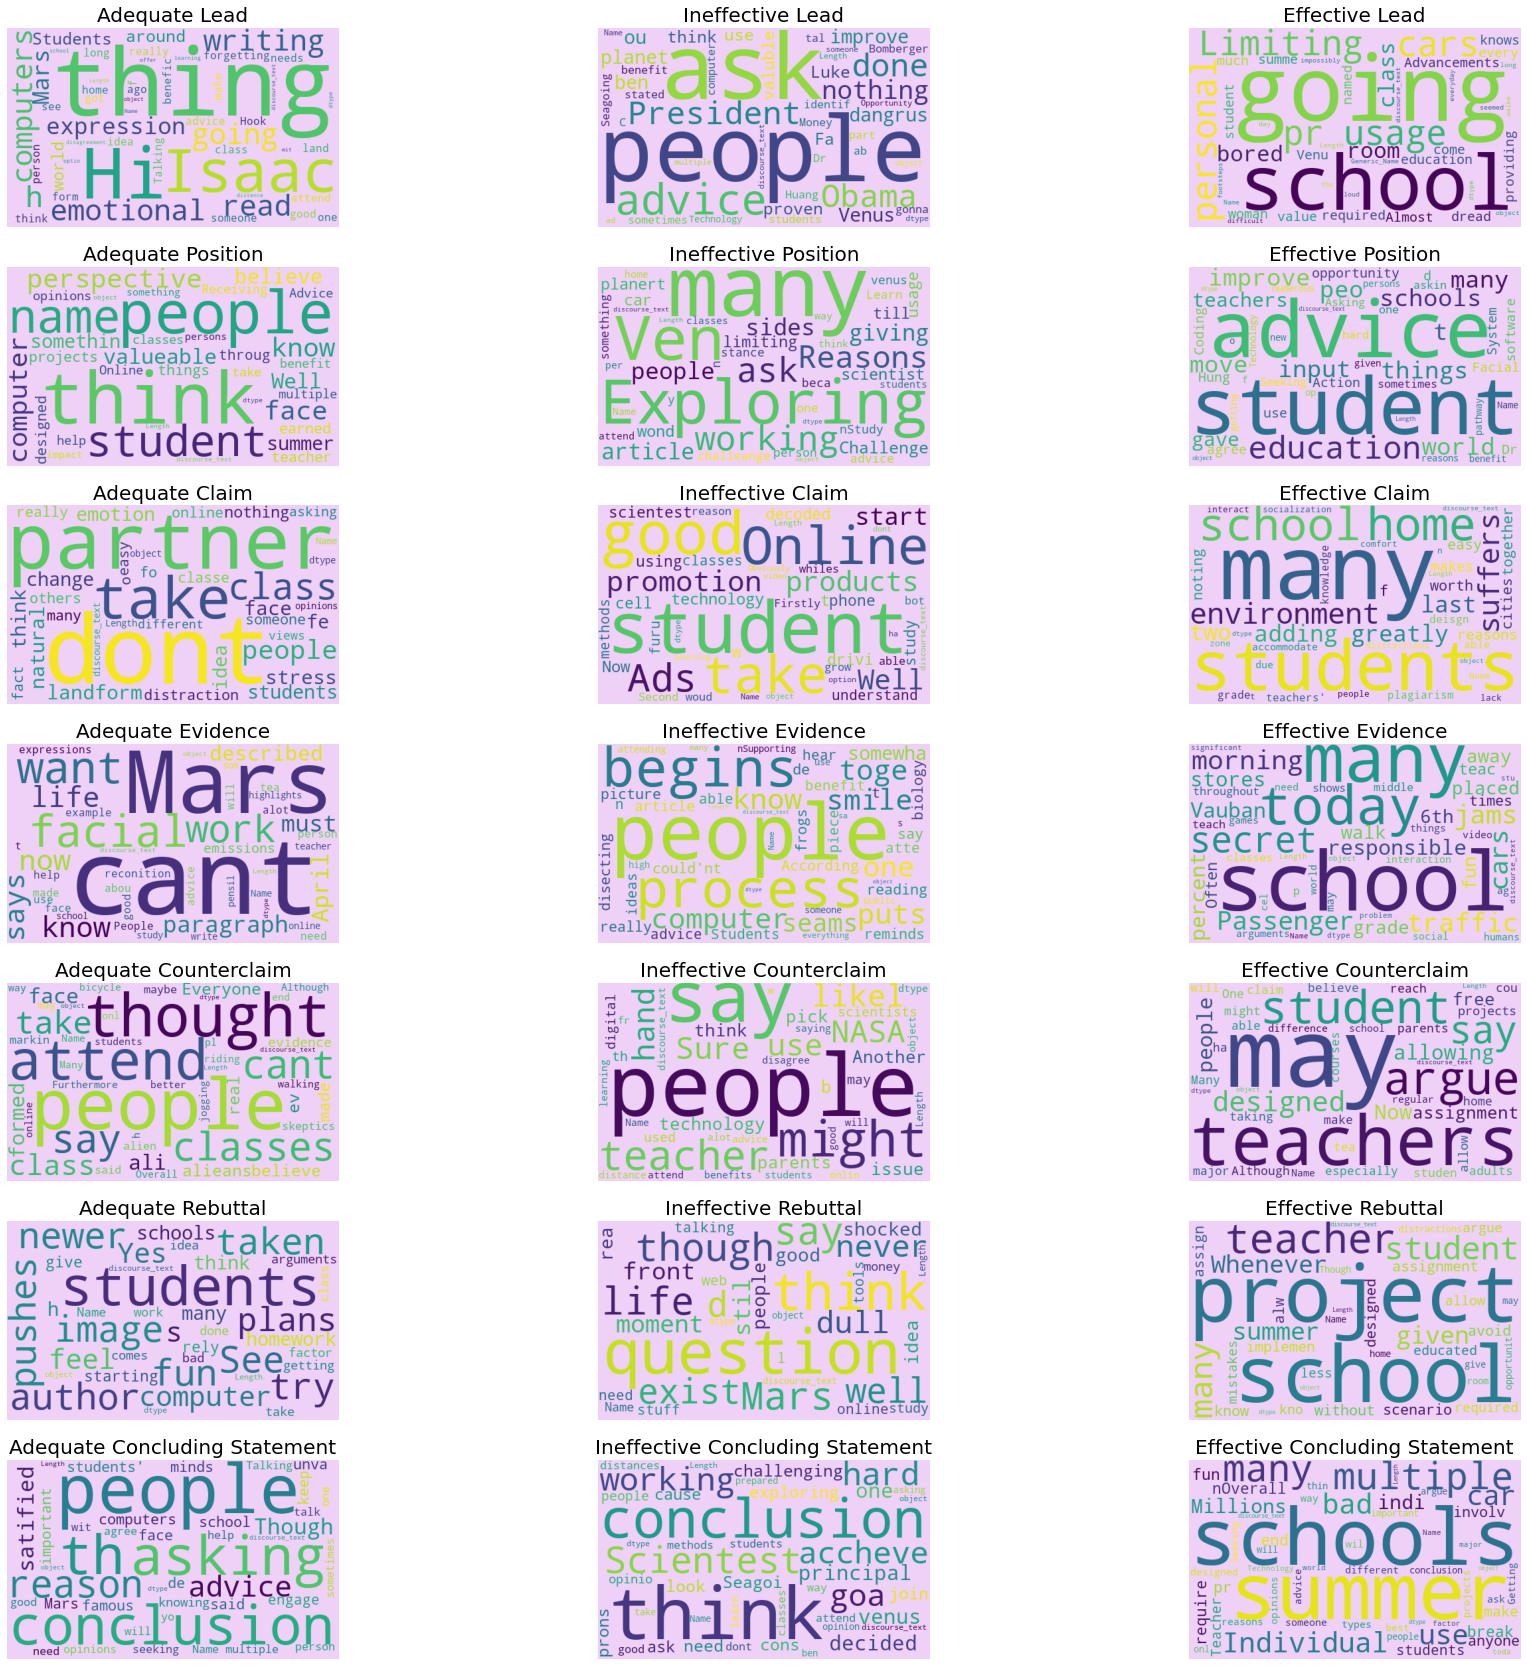

In [23]:
fig, ax = plt.subplots(7, 3, sharex = "col", sharey = "row", figsize = (30, 30))
for i, disty in enumerate(data["discourse_type"].unique()):
    for j, effect in enumerate(set(data["discourse_effectiveness"].values)):
            word_cloud = WordCloud(background_color = "#EFD0F7", width = 500, height = 300,
                                   max_words = 100).generate(str(data.query(f'discourse_type == "{disty}" and discourse_effectiveness=="{effect}"')['discourse_text']))
            ax[i,j].imshow(word_cloud)
            ax[i,j].axis("off");
            ax[i,j].set_title(f'{effect } {disty}', fontsize = 20);
            
plt.show()

This graphs show some words that 